In [2]:
from pyspark.sql import SparkSession

# SparkSession 생성
spark = SparkSession.builder \
    .appName("Ironman Data Analysis") \
    .getOrCreate()

# 파일 경로 설정
file_path = "file:///home/lab12/src/data/2024_ironman.csv"

# CSV 파일 읽기
df = spark.read.csv(file_path, header=True, inferSchema=True)

# 데이터 확인
df.show()  # 첫 20개 행 출력
df.printSchema()  # 데이터 스키마 확인


+---+-----------------+-------------+------+--------+-------------+------------+------------+---------+---------+---------+---------+--------+--------+-------------+
|Bib|             Name|      Country|Gender|Division|Division Rank|Overall Time|Overall Rank|Swim Time|Swim Rank|Bike Time|Bike Rank|Run Time|Run Rank|Finish Status|
+---+-----------------+-------------+------+--------+-------------+------------+------------+---------+---------+---------+---------+--------+--------+-------------+
|284|    Sergei Khazov|   Kazakhstan|  Male|  M40-44|            1|     8:43:25|           1| 56:20:00|        3|  4:32:10|        3| 3:09:03|       3|     Finisher|
|  6|      Sanghwan Oh|        Korea|  Male|  M50-54|            1|     8:52:37|           2|  1:15:00|       54|  4:20:06|        2| 3:11:19|       4|     Finisher|
| 11|   Brenteson John|United States|  Male|  M30-34|            1|     9:06:06|           3|  1:00:20|        6|  4:43:08|        6| 3:17:23|       6|     Finisher|
| 42

In [3]:
# 데이터 요약 통계
df.describe().show()

# 전체 데이터 행 수 확인
print(f"Row count: {df.count()}")


+-------+------------------+-------+-------+------+--------+------------------+------------+------------------+---------+------------------+---------+-----------------+--------+------------------+-------------+
|summary|               Bib|   Name|Country|Gender|Division|     Division Rank|Overall Time|      Overall Rank|Swim Time|         Swim Rank|Bike Time|        Bike Rank|Run Time|          Run Rank|Finish Status|
+-------+------------------+-------+-------+------+--------+------------------+------------+------------------+---------+------------------+---------+-----------------+--------+------------------+-------------+
|  count|               715|    715|    715|   715|     715|               521|         521|               521|      567|               567|      553|              553|     530|               530|          715|
|   mean| 361.6307692307692|   null|   null|  null|    null| 30.49328214971209|        null|             261.0|     null|             284.0|     null|      

In [4]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

# 시간을 초 단위로 변환하는 함수
def time_to_seconds(time_str):
    try:
        h, m, s = map(int, time_str.split(":"))
        return h * 3600 + m * 60 + s
    except:
        return None

# UDF 등록
time_to_seconds_udf = udf(time_to_seconds, IntegerType())

# 시간 데이터를 초 단위로 변환
df = df.withColumn("Overall Time (s)", time_to_seconds_udf(df["Overall Time"]))
df = df.withColumn("Swim Time (s)", time_to_seconds_udf(df["Swim Time"]))
df = df.withColumn("Bike Time (s)", time_to_seconds_udf(df["Bike Time"]))
df = df.withColumn("Run Time (s)", time_to_seconds_udf(df["Run Time"]))

# 변환된 데이터 확인
df.select("Name", "Overall Time", "Overall Time (s)", "Swim Time (s)", "Bike Time (s)", "Run Time (s)").show()


+-----------------+------------+----------------+-------------+-------------+------------+
|             Name|Overall Time|Overall Time (s)|Swim Time (s)|Bike Time (s)|Run Time (s)|
+-----------------+------------+----------------+-------------+-------------+------------+
|    Sergei Khazov|     8:43:25|           31405|       202800|        16330|       11343|
|      Sanghwan Oh|     8:52:37|           31957|         4500|        15606|       11479|
|   Brenteson John|     9:06:06|           32766|         3620|        16988|       11843|
|Evgeniy Perevalov|     9:22:41|           33761|         3953|        17581|       11888|
|       Zijie Chen|     9:23:18|           33798|         4100|        16978|       12360|
|    Hyungeun Kang|     9:25:22|           33922|         3914|        17221|       12350|
| Diana Trubkovich|     9:30:46|           34246|       202980|        18517|       11999|
|    Tsuyoshi Ohno|     9:35:24|           34524|         4035|        17497|       12528|

In [5]:
from pyspark.sql.functions import col

# 국가별 참가자 수 집계
country_count = df.groupBy("Country").count().orderBy(col("count").desc())
country_count.show()


+--------------+-----+
|       Country|count|
+--------------+-----+
|         Korea|  521|
|         China|   25|
|   Philippines|   24|
| United States|   21|
|        France|   20|
|       Unknown|   19|
|         Japan|   16|
|        Canada|    9|
|         India|    9|
|    Kazakhstan|    5|
|United Kingdom|    5|
|         Spain|    4|
|     Singapore|    4|
|       Armenia|    3|
|      Malaysia|    3|
|      Pakistan|    3|
|     Indonesia|    3|
|    Uzbekistan|    2|
|       Vietnam|    2|
|       Germany|    2|
+--------------+-----+
only showing top 20 rows



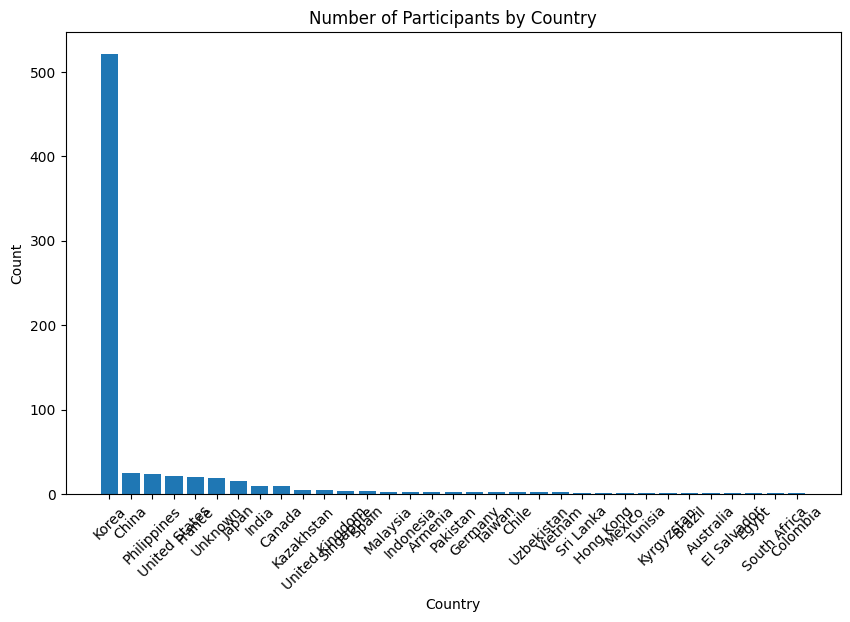

In [6]:
# Pandas 변환
country_count_pd = country_count.toPandas()

# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(country_count_pd["Country"], country_count_pd["count"])
plt.title("Number of Participants by Country")
plt.xlabel("Country")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [7]:
df.groupBy("Gender").avg("Overall Time (s)").show()


+------+---------------------+
|Gender|avg(Overall Time (s))|
+------+---------------------+
|Female|    48307.01515151515|
|  Male|    47298.03956043956|
+------+---------------------+



In [8]:
df.groupBy("Division").count().orderBy("count", ascending=False).show()


+--------+-----+
|Division|count|
+--------+-----+
|  M45-49|  111|
|  M40-44|  104|
|  M50-54|   99|
|  M35-39|   77|
|  M55-59|   71|
|  M60-64|   41|
|  M30-34|   36|
|  F30-34|   28|
|  F45-49|   19|
|  F50-54|   17|
|  F25-29|   17|
|  F18-24|   16|
|  M25-29|   14|
|  F55-59|   13|
|  M65-69|   12|
|  M18-24|   11|
|  F35-39|   11|
|  F40-44|   10|
|  F60-64|    3|
|  F65-69|    2|
+--------+-----+
only showing top 20 rows



In [9]:
from pyspark.sql.functions import col

# 전체 참가자 수
total_participants = df.count()

# 완주자 수 (Finish Status가 "Finisher"인 경우)
finishers = df.filter(col("Finish Status") == "Finisher").count()

# 완주 비율 계산
completion_rate = (finishers / total_participants) * 100

print(f"Total Participants: {total_participants}")
print(f"Finishers: {finishers}")
print(f"Completion Rate: {completion_rate:.2f}%")


Total Participants: 715
Finishers: 521
Completion Rate: 72.87%


In [10]:
# 완주 여부 열 추가
df = df.withColumn("Completed", (col("Finish Status") == "Finisher").cast("integer"))

# 데이터 확인
df.select("Name", "Finish Status", "Completed").show()

# 완주 비율 계산 (데이터프레임에서)
completion_rate_df = df.groupBy("Completed").count()
completion_rate_df.show()


+-----------------+-------------+---------+
|             Name|Finish Status|Completed|
+-----------------+-------------+---------+
|    Sergei Khazov|     Finisher|        1|
|      Sanghwan Oh|     Finisher|        1|
|   Brenteson John|     Finisher|        1|
|Evgeniy Perevalov|     Finisher|        1|
|       Zijie Chen|     Finisher|        1|
|    Hyungeun Kang|     Finisher|        1|
| Diana Trubkovich|     Finisher|        1|
|    Tsuyoshi Ohno|     Finisher|        1|
|     Yong Jin Kim|     Finisher|        1|
|          박 진홍|     Finisher|        1|
|      Xinwei Qian|     Finisher|        1|
|      Hyeonsu Lee|     Finisher|        1|
|     Dong Kyu Kim|     Finisher|        1|
|          鹏飞 王|     Finisher|        1|
|     Ling Er Choo|     Finisher|        1|
|   Seung Hwan Lee|     Finisher|        1|
|     Kwangwon Kim|     Finisher|        1|
|          창연 이|     Finisher|        1|
|    Hyungwon Moon|     Finisher|        1|
|     Yong Hyo Lee|     Finisher|        

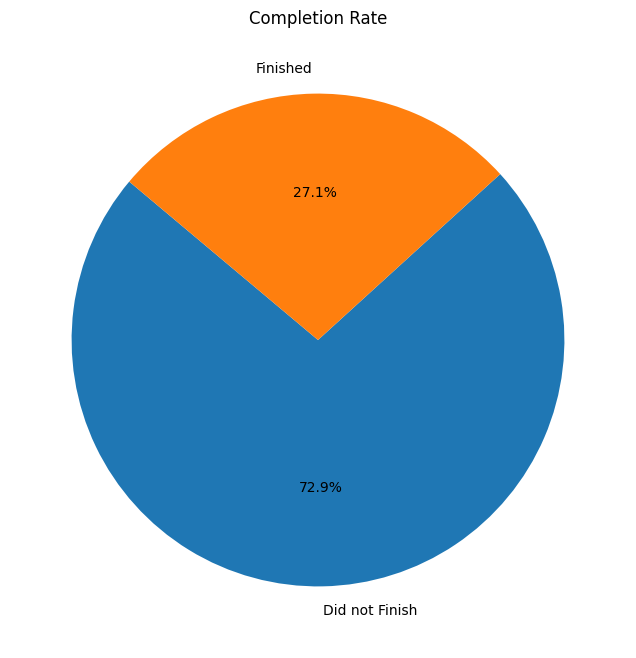

In [11]:
# Pandas 변환
completion_rate_pd = completion_rate_df.toPandas()

# 시각화
import matplotlib.pyplot as plt

labels = ["Did not Finish", "Finished"]
sizes = completion_rate_pd["count"]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140)
plt.title("Completion Rate")
plt.show()


In [50]:
from pyspark.sql import SparkSession

# Spark 세션 초기화
spark = SparkSession.builder.appName("Ironman Data Analysis").getOrCreate()

# CSV 다시 불러오기
file_path = "file:///home/lab12/src/data/2024_ironman.csv"  # 정확한 경로 입력
df = spark.read.csv(file_path, header=True, inferSchema=True)

# 데이터 확인
df.show(truncate=False)
df.printSchema()


+---+-----------------+-------------+------+--------+-------------+------------+------------+---------+---------+---------+---------+--------+--------+-------------+
|Bib|Name             |Country      |Gender|Division|Division Rank|Overall Time|Overall Rank|Swim Time|Swim Rank|Bike Time|Bike Rank|Run Time|Run Rank|Finish Status|
+---+-----------------+-------------+------+--------+-------------+------------+------------+---------+---------+---------+---------+--------+--------+-------------+
|284|Sergei Khazov    |Kazakhstan   |Male  |M40-44  |1            |8:43:25     |1           |56:20:00 |3        |4:32:10  |3        |3:09:03 |3       |Finisher     |
|6  |Sanghwan Oh      |Korea        |Male  |M50-54  |1            |8:52:37     |2           |1:15:00  |54       |4:20:06  |2        |3:11:19 |4       |Finisher     |
|11 |Brenteson John   |United States|Male  |M30-34  |1            |9:06:06     |3           |1:00:20  |6        |4:43:08  |6        |3:17:23 |6       |Finisher     |
|42 

In [53]:
spark.stop()